In [1]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [2]:
dsm = 'DSM_LondonCity_1m.tif'
shp = 'drone_pos_32631.gml'
drones = gpd.read_file(shp)
dsm_show = rasterio.open(dsm)

drones.head()

C:\Users\xbacos\Anaconda3\envs\geo_py\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,fid,id,left,top,right,bottom,geometry
0,drone_pos.0,1,530866.4114,181947.5698,530966.4114,182047.5698,POINT (283895.042 5712398.431)
1,drone_pos.1,2,530866.4114,181847.5698,530966.4114,181947.5698,POINT (283888.211 5712298.629)
2,drone_pos.2,3,530866.4114,181747.5698,530966.4114,181847.5698,POINT (283881.380 5712198.826)
3,drone_pos.3,4,530866.4114,181647.5698,530966.4114,181747.5698,POINT (283874.549 5712099.024)
4,drone_pos.4,5,530866.4114,181547.5698,530966.4114,181647.5698,POINT (283867.718 5711999.221)


In [3]:
# Settings for buffer
style = 3 # 1 circle 3 square
radius = 100.

# Buffer around points using 'geometry columsä
drones['buff'] = drones['geometry'].buffer(radius, cap_style=3)
drones.head()

,fid,id,left,top,right,bottom,geometry,buff
0,drone_pos.0,1,530866.4114,181947.5698,530966.4114,182047.5698,POINT (283895.042 5712398.431),"POLYGON ((283945.042 5712448.431, 283945.042 5..."
1,drone_pos.1,2,530866.4114,181847.5698,530966.4114,181947.5698,POINT (283888.211 5712298.629),"POLYGON ((283938.211 5712348.629, 283938.211 5..."
2,drone_pos.2,3,530866.4114,181747.5698,530966.4114,181847.5698,POINT (283881.380 5712198.826),"POLYGON ((283931.380 5712248.826, 283931.380 5..."
3,drone_pos.3,4,530866.4114,181647.5698,530966.4114,181747.5698,POINT (283874.549 5712099.024),"POLYGON ((283924.549 5712149.024, 283924.549 5..."
4,drone_pos.4,5,530866.4114,181547.5698,530966.4114,181647.5698,POINT (283867.718 5711999.221),"POLYGON ((283917.718 5712049.221, 283917.718 5..."


## Visualise buffers on Dsm


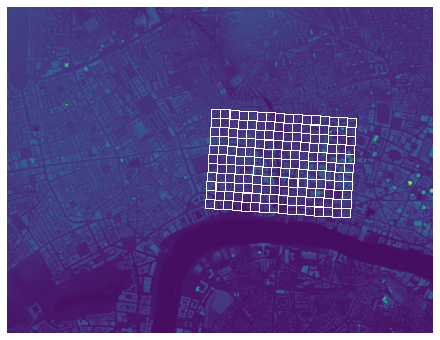

<AxesSubplot:>

In [16]:
drones['buff'].plot(facecolor = 'none' , edgecolor='white', figsize = (10,6)).axis('off')
show(dsm_show)


## Calculate zonal statistics for each buffer zone using zonal_stats()


In [5]:
drones_zonal_stats = drones.join(pd.DataFrame(zonal_stats(drones['buff'],dsm)))

drones_zonal_stats.head()


,fid,id,left,top,right,bottom,geometry,buff,min,max,mean,count
0,drone_pos.0,1,530866.4114,181947.5698,530966.4114,182047.5698,POINT (283895.042 5712398.431),"POLYGON ((283945.042 5712448.431, 283945.042 5...",19.753780,49.054951,28.058175,10000
1,drone_pos.1,2,530866.4114,181847.5698,530966.4114,181947.5698,POINT (283888.211 5712298.629),"POLYGON ((283938.211 5712348.629, 283938.211 5...",20.218731,51.697880,28.164697,10000
2,drone_pos.2,3,530866.4114,181747.5698,530966.4114,181847.5698,POINT (283881.380 5712198.826),"POLYGON ((283931.380 5712248.826, 283931.380 5...",20.181900,46.236061,28.985122,10000
3,drone_pos.3,4,530866.4114,181647.5698,530966.4114,181747.5698,POINT (283874.549 5712099.024),"POLYGON ((283924.549 5712149.024, 283924.549 5...",18.743660,67.372231,38.485231,10000
4,drone_pos.4,5,530866.4114,181547.5698,530966.4114,181647.5698,POINT (283867.718 5711999.221),"POLYGON ((283917.718 5712049.221, 283917.718 5...",18.865000,57.344311,29.325781,10000


## Plot mean height from zonal statistics. Change geometry column to buffer instead of point


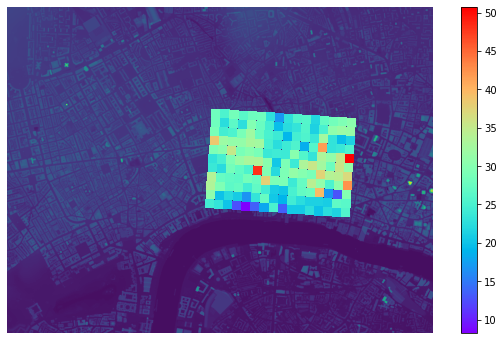

<AxesSubplot:>

In [17]:
drones_zonal_stats.set_geometry('buff').plot(column = 'mean', cmap = 'rainbow', figsize = (10,6), legend = True).axis('off')
show(dsm_show)



## Print to .txt using specified columns

In [7]:

drones_zonal_stats.set_index('id')[['mean','min','max']].to_csv('dropneheight.txt',sep='\t')
